In [1]:
import gc
import time
import os

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn

from tensorflow.python.client import device_lib


from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

import mne

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Flatten


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.test.gpu_device_name()

''

### Loading edf

In [5]:
file = "..\dataverse_files\h01.edf"
edfs_path = "..\dataverse_files"
manifest_path = "..\dataverse_files\MANIFEST.txt"

In [6]:
def load_patients_data(edfs_path):
    raw_patients_data = []
    
    edfs_file_names = [f for f in os.listdir(edfs_path) if f.endswith('.edf')]
    
    for file_name in edfs_file_names:
        path = edfs_path + '\\' + file_name 
        raw_data = mne.io.read_raw_edf(path, preload=True, verbose=False)
        raw_patients_data.append(raw_data)

    return raw_patients_data

In [7]:
raw_patients_data = load_patients_data(edfs_path)

### Filtered EEG signals segmentation

In [8]:
def get_label(edf):
    patient_edf_file_name = edf.filenames[0].split('\\')[-1]
    isSick = patient_edf_file_name.lower().startswith('s')
    return int(isSick == True) # 1 - is sick, 0 is healthy

In [9]:
def get_min_max_duration_for_classes(print_durations=False):
    min_SZ_negative_duration = float("inf") # healthy
    min_SZ_positive_duration = float("inf") # sick

    max_SZ_negative_duration = 0 # healthy
    max_SZ_positive_duration = 0 # sick

    for edf in raw_patients_data:
        duration = edf.times[-1]

        if(get_label(edf) == 0):
            min_SZ_negative_duration = duration if duration < min_SZ_negative_duration else min_SZ_negative_duration
            max_SZ_negative_duration = duration if duration > max_SZ_negative_duration else max_SZ_negative_duration
        else:
            min_SZ_positive_duration = duration if duration < min_SZ_positive_duration else min_SZ_positive_duration
            max_SZ_positive_duration = duration if duration > max_SZ_positive_duration else max_SZ_positive_duration


    print('SZ_negative: min =', min_SZ_negative_duration, ', max =', max_SZ_negative_duration)
    print('SZ_positive: min =', min_SZ_positive_duration, ', max =', max_SZ_positive_duration)
    
    return min_SZ_negative_duration, min_SZ_positive_duration, max_SZ_negative_duration, max_SZ_positive_duration

In [10]:
def crop_raw_data_to_equalize_duration_per_class():
    print("Duration per class before cropping: ")
    min_dur_neg, min_dur_pos, *_ = get_min_max_duration_for_classes(True)
    
    for edf in raw_patients_data:
        duration = edf.times[-1]

        if(get_label(edf) == 0):
            if(duration > min_dur_neg):
                edf.crop(tmin=0, tmax=min_dur_neg, include_tmax=True)
        else:
            if(duration > min_dur_pos):
                edf.crop(tmin=0, tmax=min_dur_pos, include_tmax=True)
                
    print("\nDuration per class after cropping: ")

    get_min_max_duration_for_classes(True)


In [11]:
def print_info(epochs_num_per_patient, labels):
    print('\nEpochs number per patient: ', epochs_num_per_patient)
    
    class_SZ_positive = sum(labels) 
    class_SZ_negative= len(labels)-sum(labels)

    print('\nnegative: ', class_SZ_positive)
    print('positive: ', class_SZ_negative)

In [12]:
def transform_patients_data_into_X_y_sets(patients_data, segment_duration=5.0, info=True):
    epochs_per_patient = []
    labels = []
    
    epochs_num_per_patient = []
    for edf in raw_patients_data:
        epochs = mne.make_fixed_length_epochs(edf, duration=segment_duration, preload=True, verbose=False)
        epochs_per_patient.append(epochs)
        epochs_num_per_patient.append(len(epochs))
        
        label = get_label(edf)
        labels.extend([label for epoch in epochs])
    
    epochs = mne.concatenate_epochs(epochs_per_patient)

    if info:
        print_info(epochs_num_per_patient, labels)
        
    del epochs_num_per_patient
    gc.collect()
    
    return (epochs, np.array(labels)) # (X, y)

In [13]:
# crop_raw_data_to_equalize_duration_per_class()

In [14]:
X, y = transform_patients_data_into_X_y_sets(patients_data=raw_patients_data, segment_duration=5.0)

Not setting metadata
5771 matching events found
No baseline correction applied
0 bad epochs dropped

Epochs number per patient:  [185, 182, 182, 185, 189, 186, 182, 182, 181, 223, 183, 180, 193, 173, 169, 229, 192, 241, 178, 148, 269, 182, 237, 170, 272, 217, 227, 434]

negative:  3165
positive:  2606


In [15]:
del raw_patients_data
gc.collect()

0

In [16]:
print(len(y))
print(len(X))
print(X[0].get_data().shape)

5771
5771
(1, 19, 1250)


In [17]:
X.to_data_frame().head()

,time,condition,epoch,Fp2,F8,T4,T6,O2,Fp1,F7,...,O1,F4,C4,P4,F3,C3,P3,Fz,Cz,Pz
0,0,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
1,4,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
2,8,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
3,12,1,0,0.461215,0.461215,0.308310,0.30831,0.155405,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.303310
4,16,1,0,0.461215,0.461215,0.461215,0.30831,0.155405,0.0025,0.0025,...,-0.30331,0.0025,0.155405,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.150405


In [18]:
X[0].to_data_frame().head()

,time,condition,epoch,Fp2,F8,T4,T6,O2,Fp1,F7,...,O1,F4,C4,P4,F3,C3,P3,Fz,Cz,Pz
0,0,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
1,4,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
2,8,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
3,12,1,0,0.461215,0.461215,0.308310,0.30831,0.155405,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.303310
4,16,1,0,0.461215,0.461215,0.461215,0.30831,0.155405,0.0025,0.0025,...,-0.30331,0.0025,0.155405,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.150405


In [19]:
X_shape = X[0].get_data().shape
X_shape = (len(X), X_shape[2], X_shape[1])
X_shape

(5771, 1250, 19)

In [20]:
X_data = np.zeros(shape=X_shape)
print(X_data.shape)

for i in range(len(X)):
    df = X[i].to_data_frame().drop(['time', 'condition', 'epoch'], axis=1)
#     np.concatenate(x_data, df.to_numpy())
    epoch_data = df.to_numpy()
    X_data[i] = epoch_data
    


(5771, 1250, 19)


In [21]:
input_shape = (X_data.shape[1], X_data.shape[2]) # (5000, 19)
input_shape

(1250, 19)

In [22]:
# X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.2, shuffle=True, random_state=1337)
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, shuffle=True, random_state=1337)

In [23]:
X_train.shape

(4616, 1250, 19)

In [24]:
X_test.shape

(1155, 1250, 19)

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

In [27]:
from tensorflow.keras import layers

def build_model(input_shape, opt):    

    model = Sequential()
    model.add(layers.LSTM(100,input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
#     model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=opt, 
          loss='binary_crossentropy',
          metrics=['accuracy'])
    
    return model

In [28]:
opt = opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)

In [29]:
model = build_model(input_shape, opt)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               48000     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,265
Trainable params: 51,265
Non-trainable params: 0
_________________________________________________________________


In [31]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='../vgg16/V1/weights/model.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=25,
                           restore_best_weights=True,
                           mode='max')

In [32]:
history = model.fit(
    x=X_train, 
    y=y_train.reshape(-1,1),
    batch_size=32,
    validation_split=0.2,
    epochs=300, 
#     callbacks=[tl_checkpoint_1, early_stop],
    callbacks=[early_stop],
    verbose=1)

Epoch 1/300
116/116 [==============================] - 80s 676ms/step - loss: 0.6260 - accuracy: 0.6319 - val_loss: 0.5648 - val_accuracy: 0.6807
Epoch 2/300
116/116 [==============================] - 77s 662ms/step - loss: 0.5335 - accuracy: 0.7175 - val_loss: 0.5070 - val_accuracy: 0.7348
Epoch 3/300
116/116 [==============================] - 77s 662ms/step - loss: 0.4407 - accuracy: 0.7871 - val_loss: 0.4492 - val_accuracy: 0.7879
Epoch 4/300
116/116 [==============================] - 77s 662ms/step - loss: 0.3414 - accuracy: 0.8529 - val_loss: 0.3633 - val_accuracy: 0.8582
Epoch 5/300
116/116 [==============================] - 77s 665ms/step - loss: 0.3509 - accuracy: 0.8743 - val_loss: 0.3681 - val_accuracy: 0.8561
Epoch 6/300
116/116 [==============================] - 78s 671ms/step - loss: 0.3818 - accuracy: 0.8516 - val_loss: 0.4330 - val_accuracy: 0.8009
Epoch 7/300
116/116 [==============================] - 77s 664ms/step - loss: 0.3069 - accuracy: 0.8757 - val_loss: 0.3198 -

Epoch 57/300
116/116 [==============================] - 83s 717ms/step - loss: 0.1075 - accuracy: 0.9697 - val_loss: 0.1956 - val_accuracy: 0.9394
Epoch 58/300
116/116 [==============================] - 80s 689ms/step - loss: 0.1076 - accuracy: 0.9675 - val_loss: 0.1936 - val_accuracy: 0.9437
Epoch 59/300
116/116 [==============================] - 77s 663ms/step - loss: 0.1001 - accuracy: 0.9702 - val_loss: 0.3057 - val_accuracy: 0.9199
Epoch 60/300
116/116 [==============================] - 78s 672ms/step - loss: 0.1215 - accuracy: 0.9659 - val_loss: 0.2076 - val_accuracy: 0.9405
Epoch 61/300
116/116 [==============================] - 79s 685ms/step - loss: 0.1464 - accuracy: 0.9586 - val_loss: 0.1936 - val_accuracy: 0.9340
Epoch 62/300
116/116 [==============================] - 79s 684ms/step - loss: 0.1174 - accuracy: 0.9680 - val_loss: 0.1806 - val_accuracy: 0.9481
Epoch 63/300
116/116 [==============================] - 78s 669ms/step - loss: 0.0927 - accuracy: 0.9729 - val_loss: 0

In [43]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [44]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


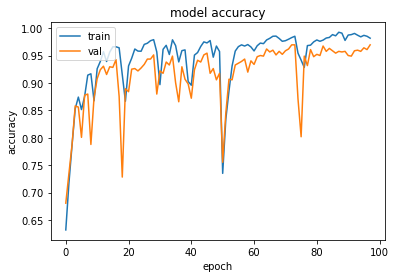

In [45]:
plot_accuracy(history)

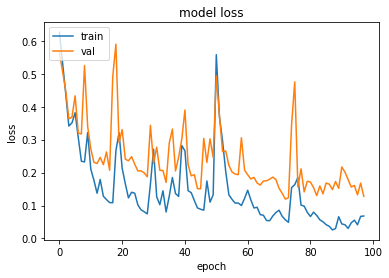

In [46]:
plot_loss(history)

In [47]:
predictions = model.predict(X_test, verbose=0)


In [48]:
predictions = np.array([0 if x < 0.5 else 1 for x in predictions])

In [49]:
print(len(predictions))
print(len(y_test))

1155
1155


In [50]:
print(predictions[0:15])
print(y_test[0:15])

[0 1 0 0 1 1 1 1 1 1 1 0 1 1 0]
[0 1 0 0 1 0 1 1 1 1 1 0 1 1 0]


In [51]:
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9454545454545454


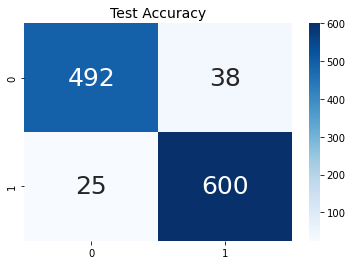

In [52]:
confusion_mtx = confusion_matrix(y_test, predictions)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax, fmt='d')
ax.set_title('Test Accuracy', size=14)
plt.show()